# Netflix content and IMDb scores: what are users watching?
For this project, I used this [Kaggle dataset](https://www.kaggle.com/shivamb/netflix-shows). It has information on all movies and TV shows that were available on Netflix US as of 2019. The data was apparently retrieved from [Flixable](https://flixable.com). I also used a couple of the official [IMDb datasets](https://datasets.imdbws.com) that have the IMDb score for each production (retrieved on 31/08/2020).

The main goal of the project is to retrieve the IMDb score for each title (a value from 1 to 10), and then explore how the scores differ depending on the content's type (movie or TV show), country of production, age rating etc.
### Here is what we're going to do:
1. Reading the dataset into pandas and cleaning it.<br><i>Libraries used: pandas. NumPy.</i>
2. Retrieving IMDb title IDs from an external API and matching them for each movie/show in the dataset.<br><i>Libraries used: requests, time, json.</i>
3. Extracting the IMDb scores for each title.
4. Generating a world map showing the countries with the most productions and their scores.<br><i>Libraries used: Matplotlib, Toolkits.</i>
5. Exploring and visualising scores across several different variables.<br><i>Libraries used: Seaborn.</i>

In [1]:
# Importing all necessary libraries.
import pandas as pd
import numpy as np
import requests
import time
import json
import unidecode
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import warnings

# Supressing future warnings that are irrelevant in our case.
warnings.filterwarnings('ignore')

# Displaying all graphs in the notebook.
%matplotlib inline

In [2]:
# Reading the dataset into a dataframe. We only need some of the columns.
netflix = pd.read_csv('netflix_titles.csv', usecols=['type', 'title', 'country', 'release_year', 'rating', 'duration'])

# Printing the number of total productions in the dataframe and the proportions of movies and TV shows in %.
production_count = netflix['type'].value_counts(normalize=True)
print('Total productions: {}\n'.format(netflix.shape[0]))
print('Type of production\n{}: {:.2f}%\n{}: {:.2f}%'.format(production_count.index[0], production_count[0] * 100, production_count.index[1], production_count[1] * 100))

Total productions: 6234

Type of production
Movie: 68.42%
TV Show: 31.58%


We can see that more than 2/3 of Netflix's catalogue consists of movies.

In [3]:
# Splitting the countries into a list and selecting only the first country as the primary country of production.
netflix['country'] = netflix['country'].str.split(', ').fillna('no country').apply(lambda x: x[0])
# Doing some additional cleaning and replacing rows with no countriies with missing values.
netflix['country'] = netflix['country'].str.replace(',', '').str.replace('West Germany', 'Germany').replace('n', np.nan)

# Taking a look at the first few rows of the dataset.
netflix.head()

,type,title,country,release_year,rating,duration
0,Movie,Norm of the North: King Sized Adventure,United States,2019,TV-PG,90 min
1,Movie,Jandino: Whatever it Takes,United Kingdom,2016,TV-MA,94 min
2,TV Show,Transformers Prime,United States,2013,TV-Y7-FV,1 Season
3,TV Show,Transformers: Robots in Disguise,United States,2016,TV-Y7,1 Season
4,Movie,#realityhigh,United States,2017,TV-14,99 min


This is how the dataset looks after we've cleaned it.

In [4]:
# Grouping the dataset by country and counting the productions for each.
netflix_top_countries = netflix.groupby('country').agg({'title':'count'})
netflix_top_countries.columns = ['count']
netflix_top_countries = netflix_top_countries.sort_values(by='count', ascending=False)
# Displaying the top 10 countries.
print(netflix_top_countries.head(10))

                count
country              
United States    2302
India             808
United Kingdom    483
Canada            206
Japan             184
France            147
South Korea       146
Spain             139
Mexico             99
Australia          94


Looks like the overwhelming majority of productions come from the US.

## Adding the IMDb scores
There are several ways to go about this. The easiest and arguably most flawed one would be to read the official IMDb dataset directly and match the Netflix title of each production with the IMDb title, and then adding the score. However, the IMDb dataset contains every production ever released (well, perhaps not the too obscure ones), and many of them have essentially the same titles. They have unique IDs though, which in this scenario are not very useful as we can't match them against anything.<br><br>Well, what if we also match by year in addition to the title? This won't work as intended for TV shows, because IMDb has the year that the show finished airing, and Netflix only has the year of the last season that is available on Netflix. And those two don't always match! Another reason for concern is that IMDb has a separate page for every episode of a given TV show, and they usually span across multiple years.<br><br>The alternative approach I chose is far from perfect but it does a pretty decent job. We're going to use an unofficial API from [RapidAPI](https://rapidapi.com) to perform a search using the title of each production and then retrieve the unique IMDb ID (also called "tconst") associated with that title. The way the search function works, we're likely to get the most popular title and not a random one. For example, when we search for the TV show "Friends", we'll get exactly that and not one of the presumably hundreds of other productions with that name. We will also get the page for the entire show and not for a random episode.<br><br>The search function most likely takes the popularity of the production into account, which is why it works so well. We don't need to be worried about accidentally fetching a very obscure show that has a zero chance of actually being on Netflix.<br><br>Of course, this approach is error-prone, so we will need to make sure afterwards that those are the true titles.

In [5]:
# Writing a function to fetch the IMDb IDs of the Netflix titles.
def get_imdb_ids():
    # Creating an empty list to hold the IDs.
    imdb_ids = []
    # Iterating over every title.
    for i, row in netflix.iterrows():
        title = row['title']

        # Making the API request.
        url = 'https://imdb-internet-movie-database-unofficial.p.rapidapi.com/film/{}''.format(title)
        headers = {
        'x-rapidapi-host': 'insert-host',
        'x-rapidapi-key': 'insert-key'
        }
        response = requests.request("GET", url, headers=headers)
        # Populating the list depending on the response.
        try:
            id_code = response.json()['id']
        except (KeyError, json.JSONDecodeError):
            imdb_ids.append('error')
        else:
            imdb_ids.append(response.json()['id'])

        # A cooldown of 30 seconds every 30 requests, so that we don't overwhelm the server.
        if i in [i for i in range(30, 7000, 30)]:
            time.sleep(10)

    # Saving the list with the IDs as a .txt file.
    with open('imdb_ids.txt', 'w') as f:
        json.dump({'imdb_id': imdb_ids}, f)
        
# get_imdb_ids()

# Reading the IDs into a dataframe.
with open('imdb_ids.txt', 'r') as f:
    imdb_ids = pd.DataFrame(json.load(f))

Now that we have the IMDb IDs, it's time that we matched them with the IMDb titles, years and eventually the scores.

In [6]:
# Reading the IMDb dataset, we only need the IDs (tconst), the title and the year (which we'll later use just for the movies).
imdb_titles = pd.read_csv('title.basics.tsv', sep='\t', usecols=['tconst', 'primaryTitle', 'startYear'])
imdb_titles.columns = ['imdb_id', 'imdb_title', 'imdb_year']
# Merging the IDs that we retrieved via the API with the IMDB dataset. It's a left merge because we only need to keep the Netflix titles, not the entire IMDB catalogue.
imdb = imdb_ids.merge(imdb_titles, how='left', on='imdb_id')

# Now, let's combine the Netflix and the IMDb datasets together. They're the same length, so this will be easy.
netflix_imdb = pd.concat([netflix, imdb], axis=1)
# Removing empty titles (those for which we couldn't retrieve the ID earlier) and resetting the index.
netflix_imdb = netflix_imdb[netflix_imdb['imdb_title'].notnull()].reset_index(drop=True)

# Displaying the first few rows.
netflix_imdb.head()

,type,title,country,release_year,rating,duration,imdb_id,imdb_title,imdb_year
0,Movie,Norm of the North: King Sized Adventure,United States,2019,TV-PG,90 min,tt9428190,Norm of the North: King Sized Adventure,2019
1,Movie,Jandino: Whatever it Takes,United Kingdom,2016,TV-MA,94 min,tt6999080,Jandino: Whatever it Takes,2016
2,TV Show,Transformers Prime,United States,2013,TV-Y7-FV,1 Season,tt1659175,Transformers Prime,2010
3,TV Show,Transformers: Robots in Disguise,United States,2016,TV-Y7,1 Season,tt3604232,Transformers: Robots in Disguise,2014
4,Movie,#realityhigh,United States,2017,TV-14,99 min,tt6119504,#REALITYHIGH,2017


In [7]:
# Now, let's combine the Netflix and the IMDb datasets together. They're the same length, so this will be easy.
netflix_imdb = pd.concat([netflix, imdb], axis=1)
# Removing empty titles (those for which we couldn't retrieve the ID earlier) and resetting the index.
netflix_imdb = netflix_imdb[netflix_imdb['imdb_title'].notnull()].reset_index(drop=True)

# Displaying the first few rows.
netflix_imdb.head()

,type,title,country,release_year,rating,duration,imdb_id,imdb_title,imdb_year
0,Movie,Norm of the North: King Sized Adventure,United States,2019,TV-PG,90 min,tt9428190,Norm of the North: King Sized Adventure,2019
1,Movie,Jandino: Whatever it Takes,United Kingdom,2016,TV-MA,94 min,tt6999080,Jandino: Whatever it Takes,2016
2,TV Show,Transformers Prime,United States,2013,TV-Y7-FV,1 Season,tt1659175,Transformers Prime,2010
3,TV Show,Transformers: Robots in Disguise,United States,2016,TV-Y7,1 Season,tt3604232,Transformers: Robots in Disguise,2014
4,Movie,#realityhigh,United States,2017,TV-14,99 min,tt6119504,#REALITYHIGH,2017


It's looking good. However, we still need to perform some extra checks to make sure that we've matched the titles correctly. We will compare the Netflix year with the IMDB year (but only for the movies, I explained above why this is not a good idea for the TV shows). We'll also check if the Netflix title matches with the IMDB title.

In [8]:
# Removing movies for which the years don't match, and resetting the index.
movie_year_bool = (netflix_imdb['type'] == 'Movie') & (netflix_imdb['release_year'] == netflix_imdb['imdb_year'])
netflix_imdb = netflix_imdb[~movie_year_bool].reset_index(drop=True)

# Decode both the Netflix and IMDb titles, so that some unicode characters (e.g. letters with accents) are concerted to their ASCII alternatives.
netflix_imdb['netflix_title'] = netflix_imdb['title'].apply(lambda x: unidecode.unidecode(x))
netflix_imdb['imdb_title'] = netflix_imdb['imdb_title'].apply(lambda x: unidecode.unidecode(x))
# Removing special characters and punctuation marks from both titles and converting the titles to lowercase.
netflix_imdb['netflix_title'] = netflix_imdb['netflix_title'].str.replace('[?;:!&.\(\),/#$]', '').str.lower()
netflix_imdb['imdb_title'] = netflix_imdb['imdb_title'].str.replace('[?;:!&.\(\),/#$]', '').str.lower()

Now that we've cleaned up the Netflix and IMDb titles, they're finally ready to be compared. We will first isolate all titles, for which the match is not 1:1, and see if any of them could be salvaged. To do that, we'll calculate the number of words that are the same in both titles, and then divide that by the total number of words contained in the shorter of the two titles. The number we'll get will tell us how much the words in the shorter title are words that are also included in the longer title.<br><br>
As an example: if the shorter title is "care bears cousins" and the longer title is "care bears and cousins", then that's three identical words divided by three (the length of the shorter title), which equals 1. This is as good as a perfect match (and those titles are obviously the same)! We'll set the threshold at .75, everything less than that will be dropped from the dataset.

In [9]:
# Isolating all titles that are not an exact match.
titles_not_matching = netflix_imdb[netflix_imdb['netflix_title'] != netflix_imdb['imdb_title']]

# Splitting the titles into lists of words.
titles_not_matching['netflix_title'] = titles_not_matching['netflix_title'].str.split()
titles_not_matching['imdb_title'] = titles_not_matching['imdb_title'].str.split()

In [10]:
# Defining the function for the title matching.
def percentage_match(df):
    counter = 0
    words_netflix_title = list(set(df['netflix_title']))
    words_imdb_title = list(set(df['imdb_title']))
    for word_netflix in words_netflix_title:
        for word_imdb in words_imdb_title:
             if word_netflix == word_imdb:
                counter += 1
    if len(words_netflix_title) >= len(words_imdb_title):
        pct_match = counter / len(words_imdb_title)
    else:
        pct_match = counter / len(words_netflix_title)
    return pct_match

# Applying the function on the dataset.
titles_not_matching['pct_match'] = titles_not_matching.apply(percentage_match, axis=1)
# Removing those productions for which the match is less than .75.
titles_to_remove = titles_not_matching[titles_not_matching['pct_match'] < .75]
netflix_imdb = netflix_imdb.drop(titles_to_remove.index, axis=0).reset_index(drop=True)

# Finally, let's also remove those productions, fir which the IMDB IDs are still the same. We can't know which one we really need, so we'll simply remove all that duplicate.
netflix_imdb = netflix_imdb.drop_duplicates('imdb_id', keep=False).reset_index(drop=True)

Now, we're finally ready to add the actual IMDb scores to the dataframe.

In [11]:
# Reading the IMDB dataset with the scores into a dataframe.
imdb_scores = pd.read_csv('title.ratings.tsv', sep='\t', usecols=['tconst', 'averageRating'])
imdb_scores.columns = ['imdb_id', 'imdb_score']

# Merging the grand dataframe with the scores.
netflix_imdb = netflix_imdb.merge(imdb_scores, how='left', on='imdb_id')
# Removing all titles, for which there are not IMDB scores for some reason (e.g. the title is not yet released).
netflix_imdb = netflix_imdb[netflix_imdb['imdb_score'].notnull()]

# Dropping columns that we don't need anymore.
netflix_imdb.drop(['imdb_id', 'imdb_title', 'netflix_title'], axis=1, inplace=True)

# Displaying the first few rows.
netflix_imdb.head()

,type,title,country,release_year,rating,duration,imdb_year,imdb_score
0,Movie,Norm of the North: King Sized Adventure,United States,2019,TV-PG,90 min,2019,3.2
1,Movie,Jandino: Whatever it Takes,United Kingdom,2016,TV-MA,94 min,2016,5.2
2,TV Show,Transformers Prime,United States,2013,TV-Y7-FV,1 Season,2010,7.9
3,TV Show,Transformers: Robots in Disguise,United States,2016,TV-Y7,1 Season,2014,6.0
4,Movie,#realityhigh,United States,2017,TV-14,99 min,2017,5.2


In [12]:
# Printing the number of total productions in the dataframe and the proportions of movies and TV shows in %, as well as the % of data lost since the beginning of thia project.
production_count = netflix_imdb['type'].value_counts(normalize=True)
print('Total productions: {}'.format(netflix_imdb.shape[0]))
print('Data lost: {:.2f}%\n'.format((netflix.shape[0] - netflix_imdb.shape[0]) / netflix.shape[0] * 100))
print('Type of production\n{}: {:.2f}%\n{}: {:.2f}%'.format(production_count.index[0], production_count[0]*100, production_count.index[1], production_count[1] * 100))

Total productions: 5127
Data lost: 17.76%

Type of production
Movie: 69.77%
TV Show: 30.23%


We can see that from the initial 6234 productions, 5127 are left, which is only about 18% of data lost! But why did we lose data at all? Possible reasons are: titles not yet released (they don't have IMDb scores but could still appear on Netflix as future releases), foreign titles that don't have an English name on IMDb; the <i>percentage_match</i> function is also not too generous, so we might have actually lost some titles that were correctly matched.

However, the proportions of movies and TV shows are almost intact, which means that our current sample is probably representative enough!. Just to make sure, let's also look at the current TOP 10 countries with the most productions.

In [13]:
# Grouping the dataset by country and counting the productions for each.
netflix_reduced_top_countries = netflix_imdb.groupby('country').agg({'title':'count'})
netflix_reduced_top_countries.columns = ['count']
netflix_reduced_top_countries = netflix_reduced_top_countries.sort_values(by='count', ascending=False)
# Displaying the top 10 countries.
print(netflix_reduced_top_countries.head(10))

                count
country              
United States    2086
India             649
United Kingdom    425
Canada            188
Japan             136
France            124
South Korea       114
Spain             109
Australia          87
Mexico             75


The list is intact for the most part, which is yet another indication that our sample is representative. This is good.
## Average IMDB scores
We can now start aggregating and visualising the IMDb scores. Let's first take the original TOP 10 countries list and create a map. To do that, we will need to import the coordinates for each country from an external dataset.

In [14]:
# Importing latituted and longitude and merging them with the main dataframe.
countries_coordinates = pd.read_csv('countries_coordinates.csv', usecols=['latitude', 'longitude', 'country'])
netflix_top_countries = netflix_top_countries.merge(countries_coordinates, how='left', on='country')

# Adding the mean IMDB scores per country.
netflix_imdb_top_countries = netflix_imdb.groupby('country').agg({'imdb_score':'mean'})
netflix_top_countries = netflix_top_countries.merge(netflix_imdb_top_countries, how='left', on='country')

# We need a dataframe with the TOP 10 countries only.
netflix_top10_countries = netflix_top_countries.head(10)

# Displaying the countries.
netflix_top10_countries

,country,count,latitude,longitude,imdb_score
0,United States,2302,37.090240,-95.712891,6.527709
1,India,808,20.593684,78.962880,6.394453
2,United Kingdom,483,55.378051,-3.435973,6.870118
3,Canada,206,56.130366,-106.346771,6.256383
4,Japan,184,36.204824,138.252924,7.305147
5,France,147,46.227638,2.213749,6.547581
6,South Korea,146,35.907757,127.766922,7.003509
7,Spain,139,40.463667,-3.749220,6.433945
8,Mexico,99,23.634501,-102.552784,6.537333
9,Australia,94,-25.274398,133.775136,6.686207


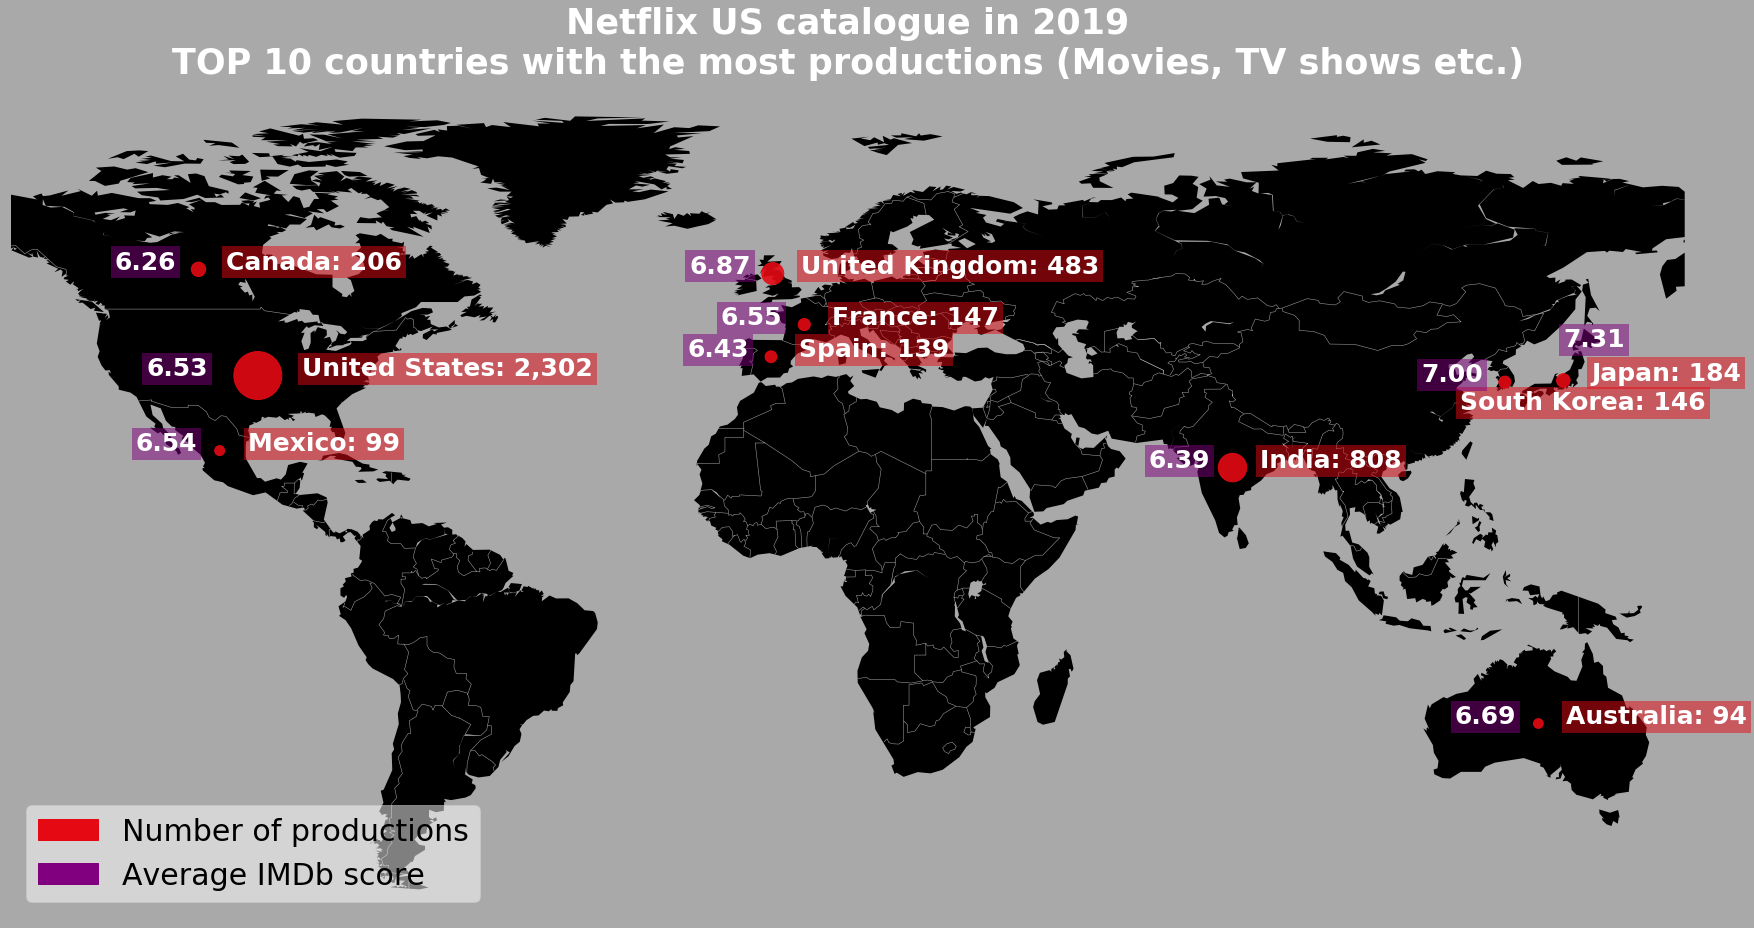

In [15]:
# Generating the map. Specifying the size of the figure.
plt.figure(figsize=(30,20), facecolor='#A9A9A9')

# Setting up parameters of the actual map.
m = Basemap(llcrnrlon=-140, llcrnrlat=-60, urcrnrlon=160, urcrnrlat=90)
m.drawmapboundary(fill_color='None', linewidth=0)
m.fillcontinents(color='black', alpha=1, lake_color='#A9A9A9')
m.drawcountries(linewidth=.5, color='#A9A9A9')

# Iterating over the countries.
for i, row in netflix_top10_countries.iterrows():
    # Adjusting the location of the labels, so that they don't overlap.
    if row['country'] == 'United States':
        x1, y1 = m(row['longitude'] + 8, row['latitude'])
        x2, y2 = m(row['longitude'] - 20, row['latitude'])
    elif row['country'] == 'South Korea':
        x1, y1 = m(row['longitude'] - 8, row['latitude'] - 5)
        x2, y2 = m(row['longitude'] - 15, row['latitude'])
    elif row['country'] == 'Japan':
        x1, y1 = m(row['longitude'] + 5, row['latitude'])
        x2, y2 = m(row['longitude'], row['latitude'] + 6)
    elif row['country'] == 'Turkey':
        x1, y1 = m(row['longitude'] + 5, row['latitude'])
        x2, y2 = m(row['longitude'], row['latitude'] - 6)
    else:
        x1, y1 = m(row['longitude'] + 5, row['latitude'])
        x2, y2 = m(row['longitude'] - 15, row['latitude'])
        
    # Adding the numbers of productions (text1) and IMDb scores (text2).
    text1 = '{}: {:,.0f}'.format(row['country'], row['count'], row['imdb_score'])
    plt.text(x1, y1, s=text1, fontsize=25, c='white', bbox=dict(facecolor='#E50914', alpha=0.5, edgecolor='None'), fontweight='bold')
    text2 = '{:,.2f}'.format(row['imdb_score'])
    plt.text(x2, y2, s=text2, fontsize=25, c='white', bbox=dict(facecolor='purple', alpha=0.5, edgecolor='None'), fontweight='bold')
    
# Adding circles with the size of the number of productions.
m.scatter(netflix_top10_countries['longitude'].to_list(), netflix_top10_countries['latitude'].to_list(), latlon=True, s=netflix_top10_countries['count'].to_list(), alpha=.9, zorder=4, c='#E50914')

# Adding semi-transparent patches behind the labels.
count = mpatches.Patch(color='#E50914', label='Number of productions')
scores = mpatches.Patch(color='purple', label='Average IMDb score')
legend = plt.legend(handles=[count, scores], loc='lower left', fontsize=30, framealpha=0.5)

# Adding a title.
plt.title('Netflix US catalogue in 2019\nTOP 10 countries with the most productions (Movies, TV shows etc.)', fontsize=35, c='white', fontweight='bold')

# Displaying the plot.
plt.show()

Apparently, Japan has the highest-rated content, while Canada the lowest. However, 6.19–7.35 is not a huge range.<br><br>We need to perform some more data manipulation before aggregating the IMDb scores. We have a <i>rating</i> column that contains the age ratings for each production. And even though they're different for movies and TV shows, they're still ordered from lowest (e.g. suitable for kids) to highest (e.g. adults only). Let's convert them to numbers.

In [16]:
# Creating a new column with the age ratings as numbers.
netflix_imdb['rating_number'] = netflix_imdb['rating'].replace(['G', 'TV-Y','PG', 'TV-Y7', 'TV-Y7-FV', 'PG-13', 'TV-G', 'R', 'TV-PG', 'NC-17', 'TV-14', 'TV-MA', 'NR', 'UR'], value=[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, np.nan, np.nan])

Turns out some of the movies are actually TV movies (their age rating starts with "TV"). Let's update the <i>type</i> column to reflect that. We'll also deal with the <i>duration</i> column after that.

In [17]:
# Updating the type column to indicate whether a movie is a TV movie.
netflix_imdb['type_new'] = np.select([(netflix_imdb['rating'].str.startswith('TV', na=False)) & (netflix_imdb['type'] == 'Movie'), (~netflix_imdb['rating'].str.startswith('TV', na=False)) & (netflix_imdb['type'] == 'Movie')], ['TV movie', 'Cinema movie'], default='TV show')

# Printing the count for each type.
print(netflix_imdb['type_new'].value_counts())

# Formatting the duration column for the movies (in minutes) and converting it to float. We don't need to do that for the TV shows because they have season, and all seasons are not always indicated.
netflix_imdb['duration_min_movie'] = np.select([netflix_imdb['type'] == 'Movie'], [netflix_imdb['duration']], default=np.nan)
netflix_imdb['duration_min_movie'] = netflix_imdb['duration_min_movie'].str.replace('[A-Za-z]+', '').astype(float)

TV movie        2458
TV show         1550
Cinema movie    1119
Name: type_new, dtype: int64


Let's visualise the mean IMDb scores for each of the three types of productions.

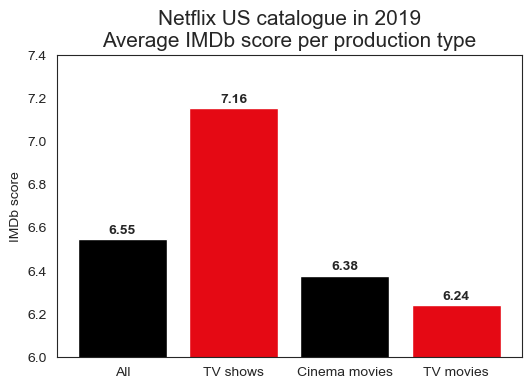

In [18]:
# Creating the dataset with the mean IMDb score for each type.
netflix_imdb_mean_scores = netflix_imdb.groupby('type_new').agg({'imdb_score':'mean'}).sort_values('imdb_score', ascending=False)
netflix_imdb_mean_scores.index = ['TV shows', 'Cinema movies', 'TV movies']
# Adding the total mean for all types.
netflix_imdb_mean_scores = pd.concat([pd.DataFrame([netflix_imdb['imdb_score'].mean()], index=['All'], columns=['imdb_score']), netflix_imdb_mean_scores])

# Setting the style of the graph.
sns.set_style('white')
# Setting the resoulution.
plt.figure(dpi=100)
# Generating the actual bar chart.
plt.bar(x=netflix_imdb_mean_scores.index, height=netflix_imdb_mean_scores['imdb_score'], color=['black', '#E50914'])
# Adjusting the y axis.
plt.ylim(6,7.4)
plt.ylabel('IMDb score')

# Adding the mean values on top of the bars.
for i, count in enumerate(netflix_imdb_mean_scores['imdb_score']):
    plt.text(i, count+.025, round(count, 2), ha='center', fontweight='bold')

plt.title('Netflix US catalogue in 2019\nAverage IMDb score per production type', fontsize=15)

plt.show()

Only TV shows get an IMDb score above 7. TV movies perform the worst, although the difference to cinema movies and all productions is by no means dramatic. 6.24–7.16 is not a huge range, and it's pretty similar to what we observed with the countries.

## IMDb score: correlation with other variables
Finally, let's plot the relationship between the IMDb scores and the continuous variables: year, duration and age rating. (The age rating is not exactly continuous but we'll treat it that way, that's why we converted the ratings to integers.) We will also calculate the correlations.

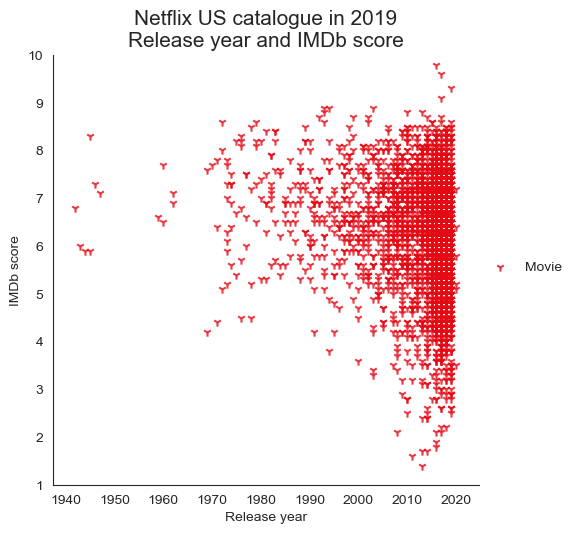

Correlation (Pearson): -0.15


In [19]:
# Creating the scatter plot for the IMDb scores and the duration.
g = sns.lmplot('release_year', 'imdb_score', data=netflix_imdb[netflix_imdb['type'] == 'Movie'], markers='1', hue='type', palette=['#E50914'], fit_reg=False)
# Adjusting the labels, legend and resolution of the plot.
g.set(ylim=(1, 10), xlabel='Release year', ylabel='IMDb score')
g._legend.set_title('')
g.fig.set_dpi(100)

plt.title('Netflix US catalogue in 2019\nRelease year and IMDb score', fontsize=15)
plt.show()

# Printing the correlation between the variables (Pearson because the variables are both continuous).
correlation = netflix_imdb.loc[netflix_imdb['type'] == 'Movie', 'imdb_score'].corr(netflix_imdb.loc[netflix_imdb['type'] == 'Movie', 'release_year'], method='pearson')
print('Correlation (Pearson): {:.2}'.format(correlation))

There is a small negative correlation between the IMDb score and the release year of the movies, which means that older movies tend to get higher ratings. However, this is mostly due to the fact that the majority of movies on the catalogue were clearly released after the 1990s. It also makes sense from a business standpoint that Netflix would bring only the highest-rated old movies on the platform, as many users probably wouldn't "waste" their time with old movies that are not that well-known and beloved.

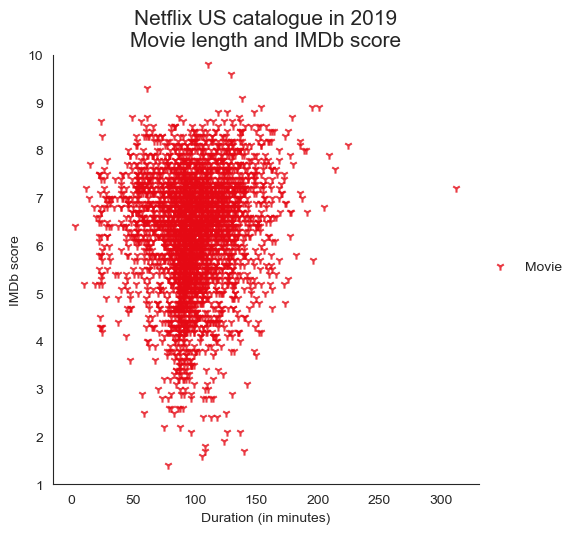

Correlation (Pearson): 0.099


In [20]:
# Creating the scatter plot for the IMDb scores and the release year.
g = sns.lmplot('duration_min_movie', 'imdb_score', data=netflix_imdb[netflix_imdb['type'] == 'Movie'], markers=['1'], hue='type', palette=['#E50914'], fit_reg=False)
g.set(ylim=(1, 10), xlabel='Duration (in minutes)', ylabel='IMDb score')
g._legend.set_title('')
g.fig.set_dpi(100)

plt.title('Netflix US catalogue in 2019\nMovie length and IMDb score', fontsize=15)
plt.show()

correlation = netflix_imdb.loc[netflix_imdb['type'] == 'Movie', 'imdb_score'].corr(netflix_imdb.loc[netflix_imdb['type'] == 'Movie', 'duration_min_movie'], method='pearson')
print('Correlation (Pearson): {:.2}'.format(correlation))

There seems to be no association between the IMDb scores and the movie length.

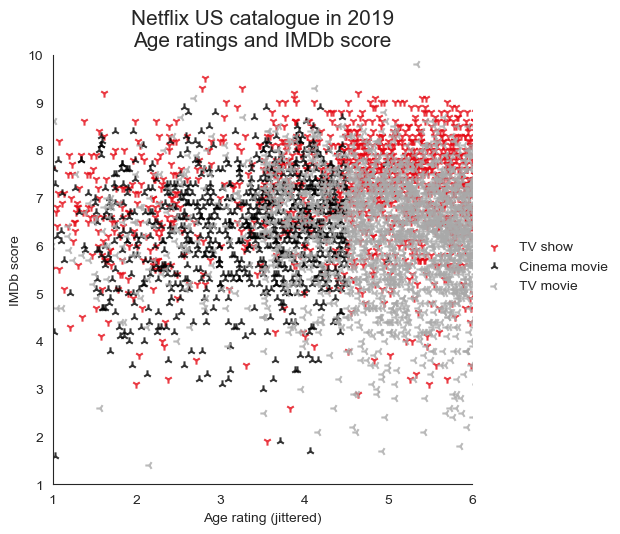

Correlations (Spearman)
TV show: 0.14
Cinema movie: 0.11
TV movie: -0.08


In [21]:
# Creating the scatter plot for the IMDb scores and the rating number.
production_types = ['TV show', 'Cinema movie', 'TV movie']
# We additionally jitter the values along the x axis to aid the visualisation (otherwise there would be large gaps between the values).
g = sns.lmplot('rating_number', 'imdb_score', hue='type_new', hue_order=production_types, data=netflix_imdb, x_jitter=.5, markers=['1', '2', '3'], palette=['#E50914', 'black', '#A9A9A9'], fit_reg=False)
g.set(xlim=(1, 6), ylim=(1, 10), xlabel='Age rating (jittered)', ylabel='IMDb score')
g._legend.set_title('')
g.fig.set_dpi(100)

plt.title('Netflix US catalogue in 2019\nAge ratings and IMDb score', fontsize=15)
plt.show()

# Printing the correlations between the variables (Spearman because the rating_number variable actually has ordered categories).
correlations = []
for each_type in production_types:
    correlation = netflix_imdb.loc[netflix_imdb['type_new'] == each_type, 'imdb_score'].corr(netflix_imdb.loc[netflix_imdb['type_new'] == each_type, 'rating_number'], method='spearman')
    correlations.append(correlation)

print('Correlations (Spearman)')
for i in range(3):
    print('{}: {:.2f}'.format(production_types[i], correlations[i]))

Again, very small correlations. TV shows and cinema movies seem to be better rated if they're for grown-ups rather than for kids. For the TV movies, it's the opposite. Again, this association is very small, so it's best not to read into it.
## Summary and conclusion
We started with a dataset of all titles on the US Netlfix in 2019 and we matched them with their respective IMDb scores, losing less than 20% of the data in the process. The mean IMDb score for all remaining shows was 6.55. TV shows had the highest average of 7.16. US was the country with most productions, with an average IMDb score of 6.53. The associations between the IMDb scores and movie release year, movie length and age rating were either small or non-existent.<br><br>Now that the IMDb scores have been matched, there are other possibilities to work with the dataset! For example, one can also utilise the categories, descriptions and cast members of the titles (they were available in the original Netflix dataset but I dropped them because they weren't relevant to the task at hand). Or one could also used some of the many other variables from the IMDb datasets. Let me know if you need need access to the matched dataset.